# TINT Demonstration


This notebook will take you through the following process:

1. DATA - Obtain nexrad data from Amazon S3
2. GRID - Map data to cartesian grids using Py-ART
3. TRACK - Perform cell tracking using TINT
4. VISUALIZE - Visualize the tracks
5. ANALYZE - Perfrom some basic analysis on the tracking output

In [1]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display
import tempfile
import os
import shutil

import pyart
from tint.data_utils import get_nexrad_keys, read_nexrad_key
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## 1. DATA


In [2]:
# Let's get some nexrad data from Amazon S3 to use for tracking
keys = get_nexrad_keys('khgx', start='20150704_123000', end='20150704_131000')

Found 9 keys.


In [3]:
# We can visualize this data using pyart and matplotlib
fig = plt.figure(figsize=(10, 7))


def plot_ppi(key):
    """ Plots ppi map of nexrad data given S3 key. """
    plt.clf()
    radar = read_nexrad_key(key)
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map('reflectivity', resolution='l',
                         sweep=3, fig=fig, width=200000, height=200000)
    del display, radar


ppi_anim = FuncAnimation(fig, plot_ppi, frames=keys, interval=1000)
HTML(ppi_anim.to_jshtml())

## 2. GRID

### Disclaimer
If you don't want this data to remain on your filesystem, make sure you run the last cell in this notebook. If your kernel crashes for some reason, you can manually remove the the path printed after the following cell.

In [4]:
# These radar volumes look interesting.
# Let's make a function that maps them to a cartesian grid using pyart.
# Most of the cells seem to be in the bottom right quadrant, so we'll only grid
# that part of the domain to save time.

def get_grid(radar):
    """ Returns grid object from radar object. """
    grid = pyart.map.grid_from_radars(
        radar, grid_shape=(20, 200, 200),
        grid_limits=((0, 10000), (-100000, 0), (0, 100000)),
        fields=['reflectivity'], gridding_algo='map_gates_to_grid')
    return grid


# Let's write these grids to a temporary location so that we can reuse them.
tmp_dir = tempfile.mkdtemp()
print('temporary directory:', tmp_dir)
filenames = []
for num, key in enumerate(keys):
    print('saving grid', num)
    radar = read_nexrad_key(key)
    grid = get_grid(radar)
    name = os.path.join(tmp_dir, 'grid_' + str(num).zfill(3) + '.nc')
    filenames.append(name)
    pyart.io.write_grid(name, grid)
    del radar, grid

temporary directory: /tmp/tmpzfkckng4
saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8


In [16]:
# Now we can easily instantiate generators of these grids like so
grids = (pyart.io.read_grid(fn) for fn in filenames)

## 3. TRACK

In [17]:
# First, let's instantiate a tracks object and view the default parameters
tracks_obj = Cell_tracks()
tracks_obj.params

{'FIELD_THRESH': 32,
 'FLOW_MARGIN': 10000,
 'GS_ALT': 1500,
 'ISO_SMOOTH': 3,
 'ISO_THRESH': 8,
 'MAX_DISPARITY': 999,
 'MAX_FLOW_MAG': 50,
 'MAX_SHIFT_DISP': 15,
 'MIN_SIZE': 8,
 'SEARCH_MARGIN': 4000}

In [18]:
# Those parameter values look fine for now. Let's try some tracking. 
# We'll give the generator of grids we made earlier to the get_tracks method of our tracks object.
tracks_obj.get_tracks(grids)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8


time elapsed 0.0 minutes


In [8]:
# Now we can view the 'tracks' attribute of our tracks object to see the results.
tracks_obj.tracks

area   grid_x   grid_y isolated      lat      lon        max  \
scan uid                                                                      
0    0    20.959067   24.771   30.181    False  28.7081 -94.9499  43.402809   
     1    21.464104  135.306   36.435    False  28.7335 -94.3830  44.481133   
     2     9.090680   87.306  164.778     True  29.3175 -94.6278  45.236401   
1    3    17.423802  143.116    7.420    False  28.6022 -94.3427  38.942795   
     0    18.181359   26.722   35.764     True  28.7352 -94.9396  40.684753   
     1    26.514482  137.048   39.257    False  28.7470 -94.3726  44.875362   
     2     9.090680   89.500  168.000     True  29.3310 -94.6122  43.964394   
2    3    15.403651  144.951    8.197    False  28.6067 -94.3324  38.217228   
     0    15.151133   28.417   41.500     True  28.7623 -94.9344  41.647053   
     1    28.534633  138.761   42.310    False  28.7605 -94.3622  42.981960   
     2    13.888538   91.836  172.364     True  29.3490 -94.6017  45.222435   
3    3    13.383500  144.811   10.755    False  28.6202 -94.3323  37.422161   
     1    29.039671  140.678   46.278    False  28.7785 -94.3517  39.627064   
     0     8.585642   30.353   46.059    False  28.7804 -94.9241  35.766544   
     2    18.938916   94.267  176.800     True  29.3716 -94.5913  43.444420   
4    3     8.080604  145.562   13.344    False  28.6292 -94.3270  35.534500   
     4     8.333123   36.061   38.152    False  28.7442 -94.8932  39.722477   
     2    16.666246   96.212  179.030     True  29.3806 -94.5809  44.419537   
5    2    12.373425   99.327  183.735    False  29.4031 -94.5652  45.938602   
6    5     8.333123  144.576   19.242    False  28.6564 -94.3320  35.186142   
     2    10.353274  101.415  186.780    False  29.4166 -94.5547  44.282158   
7    5    20.959067  145.530   21.494    False  28.6654 -94.3268  41.299484   
     6    19.443953   66.455   99.325     True  29.0195 -94.7376  40.889500   
     2    12.120906  103.854  190.333    False  29.4301 -94.5391  41.815819   
8    5    27.019520  146.065   24.645    False  28.6834 -94.3267  44.041527   
     6    16.161208   68.469  102.594     True  29.0376 -94.7273  43.931942   
     2    13.888538  107.436  194.927    False  29.4527 -94.5234  41.432789   

           max_alt                time         vol  
scan uid                                            
0    0    5.263158 2015-07-04 12:33:30   92.767461  
     1    6.315789 2015-07-04 12:33:30  122.671012  
     2    7.894737 2015-07-04 12:33:30   26.315125  
1    3    6.842105 2015-07-04 12:37:43   72.300141  
     0    4.210526 2015-07-04 12:37:43   66.186526  
     1    5.789474 2015-07-04 12:37:43  139.948619  
     2    6.842105 2015-07-04 12:37:43   31.897121  
2    3    5.789474 2015-07-04 12:41:48   59.408388  
     0    3.684211 2015-07-04 12:41:48   50.370870  
     1    5.263158 2015-07-04 12:41:48  135.562765  
     2    5.263158 2015-07-04 12:41:48   43.858542  
3    3    4.736842 2015-07-04 12:46:18   34.422310  
     1    4.210526 2015-07-04 12:46:18   96.090077  
     0    2.631579 2015-07-04 12:46:18   15.549847  
     2    5.789474 2015-07-04 12:46:18   56.617390  
4    3    1.578947 2015-07-04 12:50:43   10.233660  
     4    4.210526 2015-07-04 12:50:43   27.644172  
     2    5.263158 2015-07-04 12:50:43   49.839252  
5    2    5.789474 2015-07-04 12:55:09   41.067543  
6    5    6.315789 2015-07-04 12:59:27   28.574504  
     2    5.789474 2015-07-04 12:59:27   35.485547  
7    5    6.315789 2015-07-04 13:03:40  104.463072  
     6    5.263158 2015-07-04 13:03:40   49.440538  
     2    4.736842 2015-07-04 13:03:40   33.757787  
8    5    5.263158 2015-07-04 13:07:58  123.202630  
     6    8.947368 2015-07-04 13:07:58   61.401958  
     2    4.736842 2015-07-04 13:07:58   39.738497

## 4. VISUALIZE

In [9]:
# We can visualize these tracks to assess the performance of the algorithm.
# First we need to make another generator of the same grids for the animator
grids = (pyart.io.read_grid(fn) for fn in filenames)

In [10]:
# Let's save the animation in our temp directory so that it will be cleaned up later.
anim_name = os.path.join(tmp_dir, 'tint_demo_anim')
animate(tracks_obj, grids, os.path.join(tmp_dir, 'tint_demo_anim'))

Animating 9 frames
Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8


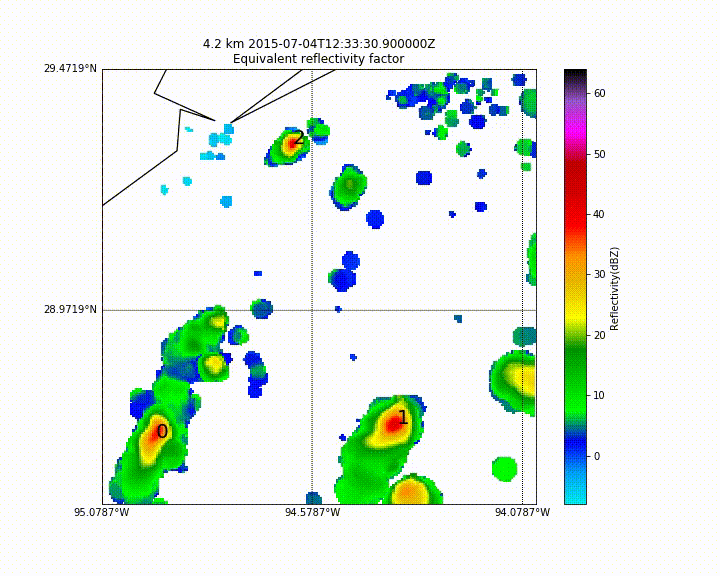

In [11]:
# The animator saved an mp4 to our local directory. Now we can embed it as a gif in this notebook.
embed_mp4_as_gif(os.path.join(tmp_dir, 'tint_demo_anim.mp4'))

In [19]:
tracks_obj.tracks.xs('2', level='uid')

,area,grid_x,grid_y,isolated,lat,lon,max,max_alt,time,vol
scan,,,,,,,,,,
0,9.090680,87.306,164.778,True,29.3175,-94.6278,45.236401,7.894737,2015-07-04 12:33:30,26.315125
1,9.090680,89.500,168.000,True,29.3310,-94.6122,43.964394,6.842105,2015-07-04 12:37:43,31.897121
2,13.888538,91.836,172.364,True,29.3490,-94.6017,45.222435,5.263158,2015-07-04 12:41:48,43.858542
3,18.938916,94.267,176.800,True,29.3716,-94.5913,43.444420,5.789474,2015-07-04 12:46:18,56.617390
4,16.666246,96.212,179.030,True,29.3806,-94.5809,44.419537,5.263158,2015-07-04 12:50:43,49.839252
5,12.373425,99.327,183.735,False,29.4031,-94.5652,45.938602,5.789474,2015-07-04 12:55:09,41.067543
6,10.353274,101.415,186.780,False,29.4166,-94.5547,44.282158,5.789474,2015-07-04 12:59:27,35.485547
7,12.120906,103.854,190.333,False,29.4301,-94.5391,41.815819,4.736842,2015-07-04 13:03:40,33.757787
8,13.888538,107.436,194.927,False,29.4527,-94.5234,41.432789,4.736842,2015-07-04 13:07:58,39.738497


## Clean Up

In [1]:
# Now we can delete the directory containing all the data and output from this demo.
shutil.rmtree(tmp_dir)
print('temporary directory removed')

NameError: name 'shutil' is not defined